In [1]:
import pandas as pd
from main import parse_current_state_log,parse_order_log, extract_position_events, extract_execution_details,load_price_data,build_trades_from_events,match_executions_to_trades,extract_trading_moments,merge_trades_with_real_pnl,flag_trades

state_logs_theo = "okx_bot_data/current_state.log"
state_logs_executed = "okx_bot_data/current_state.pos"

In [2]:
df_theo_state = parse_current_state_log(state_logs_theo)
df_theo_state

,timestamp,positions
0,2025-02-28 00:16:52.837000,"{'AXS-USDT-SWAP': 1, 'DOGE-USDT-SWAP': 1, 'ZIL..."
1,2025-02-28 03:20:54.817900,"{'AXS-USDT-SWAP': 1, 'DOGE-USDT-SWAP': 1, 'ZIL..."
2,2025-02-28 03:32:49.488100,"{'AXS-USDT-SWAP': 1, 'DOGE-USDT-SWAP': 1, 'ZIL..."
3,2025-02-28 04:14:53.948500,"{'AXS-USDT-SWAP': 1, 'DOGE-USDT-SWAP': 1, 'ZIL..."
4,2025-02-28 04:52:50.455300,"{'AXS-USDT-SWAP': 1, 'DOGE-USDT-SWAP': 1, 'ZIL..."
...,...,...
618,2025-03-11 10:12:35.773900,"{'CRO-USDT-SWAP': -1, 'BCH-USDT-SWAP': -1, 'ZE..."
619,2025-03-11 10:22:34.885900,"{'CRO-USDT-SWAP': -1, 'BCH-USDT-SWAP': -1, 'ZE..."
620,2025-03-11 10:32:43.423900,"{'CRO-USDT-SWAP': -1, 'BCH-USDT-SWAP': -1, 'ZE..."
621,2025-03-11 10:42:40.760700,"{'CRO-USDT-SWAP': -1, 'BCH-USDT-SWAP': -1, 'ZE..."


In [3]:
df_theo_events = extract_position_events(df_theo_state)
df_theo_events

,symbol,timestamp,action,old_position,new_position
0,STX-USDT-SWAP,2025-02-28 00:16:52.837000,open,0,-1
1,CFX-USDT-SWAP,2025-02-28 00:16:52.837000,open,0,-1
2,IMX-USDT-SWAP,2025-02-28 00:16:52.837000,open,0,-1
3,1INCH-USDT-SWAP,2025-02-28 00:16:52.837000,open,0,1
4,GAS-USDT-SWAP,2025-02-28 00:16:52.837000,open,0,1
...,...,...,...,...,...
435,1INCH-USDT-SWAP,2025-03-11 00:32:40.708400,close,1,0
436,EOS-USDT-SWAP,2025-03-11 00:42:38.448100,close,1,0
437,1INCH-USDT-SWAP,2025-03-11 00:42:38.448100,open,0,1
438,APT-USDT-SWAP,2025-03-11 00:48:52.214700,open,0,-1


In [3]:
def build_trades_dataframe(df_events: pd.DataFrame) -> pd.DataFrame:
    """
    Builds a trades DataFrame with entry and exit times.
    
    Returns DataFrame with:
    - symbol, entry_time, exit_time, side
    """
    open_positions = {}
    completed_trades = []

    for _, row in df_events.iterrows():
        symbol = row["symbol"]
        event_ts = row["timestamp"]
        action = row["action"]
        new_pos = row["new_position"]

        if action == "open":
            side = new_pos  # +1 or -1
            open_positions[symbol] = {
                "entry_time": event_ts,
                "side": side
            }

        elif action == "close":
            if symbol not in open_positions:
                print(f"WARNING: no open record for {symbol} at {event_ts}")
                continue

            trade_info = open_positions[symbol]
            completed_trades.append({
                "symbol": symbol,
                "entry_time": trade_info["entry_time"],
                "exit_time": event_ts,
                "side": trade_info["side"]
            })
            del open_positions[symbol]

    return pd.DataFrame(completed_trades)


def calculate_theoretical_pnl(df_trades: pd.DataFrame, df_prices: pd.DataFrame, number_of_positions = 16, exposure: float = 1.0) -> pd.DataFrame:
    """
    Calculates theoretical PNL using constant dollar exposure strategy.
    Sums (close/open - 1) over candles between entry and exit times.
    
    Args:
    - df_trades: DataFrame with symbol, entry_time, exit_time, side
    - df_prices: OHLCV DataFrame with columns like SYMBOL_open, SYMBOL_close
    - number_of_positions: number of position into which the total invested sum is equally subdivided
    - exposure: Dollar amount of exposure (default $1)
    
    Returns DataFrame with added columns:
    pnl calculate with convention of leverage 2
    - theo_pnl (cumulative PNL in percentage)
    - dollar_pnl (PNL in dollars based on exposure)
    """
    df_trades = df_trades.copy()
    df_trades["theo_pnl"] = 0.0
    df_trades["dollar_pnl"] = 0.0
    
    for idx, trade in df_trades.iterrows():
        symbol = trade["symbol"]
        entry_time = trade["entry_time"]
        exit_time = trade["exit_time"]
        side = trade["side"]
        
        # Get price columns for this symbol
        open_col = f"{symbol}_open"
        close_col = f"{symbol}_close"
        
        if open_col not in df_prices.columns or close_col not in df_prices.columns:
            print(f"WARNING: Price data missing for {symbol}")
            continue
        
        # Filter price data between entry and exit times
        mask = (df_prices.index >= entry_time) & (df_prices.index <= exit_time)
        df_period = df_prices.loc[mask, [open_col, close_col]].dropna()
        
        if df_period.empty:
            print(f"WARNING: No price data for {symbol} between {entry_time} and {exit_time}")
            continue
        
        # Calculate incremental returns for each candle
        returns = (df_period[close_col] / df_period[open_col]) - 1
        if side == -1:  # Short position: invert returns
            returns = -returns
        
        # Sum returns for total PNL percentage
        total_pnl_pcg = (returns.sum())/number_of_positions
        df_trades.loc[idx, "theo_pnl"] = total_pnl_pcg
        df_trades.loc[idx, "dollar_pnl"] = total_pnl_pcg * exposure
    
    return df_trades

In [4]:
# Paths
theo_log_path = "okx_bot_data/current_state.log"
price_path = "okx_bot_data/price_data_okx.csv"  # Your OHLCV data

# Parse theoretical positions
df_theo_log = parse_current_state_log(theo_log_path)
print("Theoretical Positions:")
print(df_theo_log.head())
print("=" * 60)

# Extract events
df_theo_events = extract_position_events(df_theo_log)
print("Theoretical Events:")
print(df_theo_events.head())
print("=" * 60)

Theoretical Positions:
                   timestamp  \
0 2025-02-28 00:16:52.837000   
1 2025-02-28 03:20:54.817900   
2 2025-02-28 03:32:49.488100   
3 2025-02-28 04:14:53.948500   
4 2025-02-28 04:52:50.455300   

                                           positions  
0  {'AXS-USDT-SWAP': 1, 'DOGE-USDT-SWAP': 1, 'ZIL...  
1  {'AXS-USDT-SWAP': 1, 'DOGE-USDT-SWAP': 1, 'ZIL...  
2  {'AXS-USDT-SWAP': 1, 'DOGE-USDT-SWAP': 1, 'ZIL...  
3  {'AXS-USDT-SWAP': 1, 'DOGE-USDT-SWAP': 1, 'ZIL...  
4  {'AXS-USDT-SWAP': 1, 'DOGE-USDT-SWAP': 1, 'ZIL...  
Theoretical Events:
           symbol               timestamp action  old_position  new_position
0  CELO-USDT-SWAP 2025-02-28 00:16:52.837   open             0             1
1  AAVE-USDT-SWAP 2025-02-28 00:16:52.837   open             0             1
2   GMX-USDT-SWAP 2025-02-28 00:16:52.837   open             0             1
3  STRK-USDT-SWAP 2025-02-28 00:16:52.837   open             0            -1
4   ETH-USDT-SWAP 2025-02-28 00:16:52.837   open 

In [5]:
# Build trades DataFrame
df_trades = build_trades_dataframe(df_theo_events)
print("Trades DataFrame:")
print(df_trades.head())
print("=" * 60)

# Load OHLCV prices
df_prices = load_price_data(price_path)
print("Price Data:")
print(df_prices.head())
print("=" * 60)


Trades DataFrame:
           symbol              entry_time                  exit_time  side
0   WOO-USDT-SWAP 2025-02-28 00:16:52.837 2025-02-28 03:20:54.817900     1
1  CELO-USDT-SWAP 2025-02-28 00:16:52.837 2025-02-28 03:32:49.488100     1
2   CFX-USDT-SWAP 2025-02-28 00:16:52.837 2025-02-28 04:14:53.948500    -1
3   ETC-USDT-SWAP 2025-02-28 00:16:52.837 2025-02-28 04:52:50.455300     1
4   UMA-USDT-SWAP 2025-02-28 00:16:52.837 2025-02-28 05:42:49.531700     1
Price Data:
                     AXS-USDT-SWAP_open  AXS-USDT-SWAP_high  \
date                                                          
2025-02-27 23:03:00               3.656               3.660   
2025-02-27 23:06:00               3.656               3.658   
2025-02-27 23:09:00               3.649               3.652   
2025-02-27 23:12:00               3.652               3.653   
2025-02-27 23:15:00               3.650               3.660   

                     AXS-USDT-SWAP_low  AXS-USDT-SWAP_close  \
date           

In [6]:
# Calculate theoretical PNL
exposure = 1.0  # $1 exposure per trade; adjust as needed
df_trades_with_pnl = calculate_theoretical_pnl(df_trades, df_prices, exposure=exposure)
print("Trades with Theoretical PNL:")
print(df_trades_with_pnl[["symbol", "entry_time", "exit_time", "side", "theo_pnl", "dollar_pnl"]])
print("=" * 60)


Trades with Theoretical PNL:
              symbol                 entry_time                  exit_time  \
0      WOO-USDT-SWAP 2025-02-28 00:16:52.837000 2025-02-28 03:20:54.817900   
1     CELO-USDT-SWAP 2025-02-28 00:16:52.837000 2025-02-28 03:32:49.488100   
2      CFX-USDT-SWAP 2025-02-28 00:16:52.837000 2025-02-28 04:14:53.948500   
3      ETC-USDT-SWAP 2025-02-28 00:16:52.837000 2025-02-28 04:52:50.455300   
4      UMA-USDT-SWAP 2025-02-28 00:16:52.837000 2025-02-28 05:42:49.531700   
..               ...                        ...                        ...   
199   BLUR-USDT-SWAP 2025-03-07 04:17:39.562100 2025-03-10 20:32:52.183300   
200    EOS-USDT-SWAP 2025-03-10 10:28:39.477300 2025-03-11 00:30:00.000000   
201  1INCH-USDT-SWAP 2025-03-11 00:30:00.000000 2025-03-11 00:32:40.708400   
202    EOS-USDT-SWAP 2025-03-11 00:32:40.708400 2025-03-11 00:42:38.448100   
203    IMX-USDT-SWAP 2025-03-10 17:12:47.784100 2025-03-11 00:48:52.214700   

     side  theo_pnl  dollar_pnl  


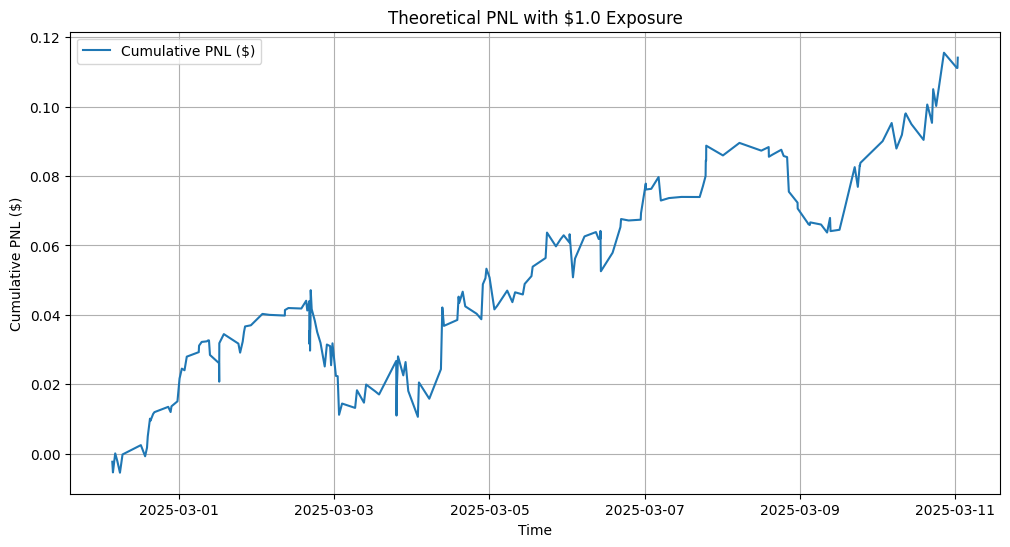

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Save results
df_trades_with_pnl.to_csv("theoretical_trades_with_pnl.csv", index=False)

# Optional: Plot cumulative PNL
df_trades_with_pnl.sort_values("exit_time", inplace=True)
df_trades_with_pnl["cumulative_dollar_pnl"] = (df_trades_with_pnl["dollar_pnl"].cumsum())
plt.figure(figsize=(12, 6))
plt.plot(df_trades_with_pnl["exit_time"].to_numpy(), df_trades_with_pnl["cumulative_dollar_pnl"].to_numpy(), label="Cumulative PNL ($)")
plt.xlabel("Time")
plt.ylabel("Cumulative PNL ($)")
plt.title(f"Theoretical PNL with ${exposure} Exposure")
plt.legend()
plt.grid()
plt.savefig("cumulative_theo_pnl.png", dpi=300)
plt.show()

In [31]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

def parse_executed_positions_log(log_path: str) -> pd.DataFrame:
    """
    Reads current_state.pos (executed positions) for OKX, ignoring 'equity' field.
    Format: 2025/03/01 12:20:38.977684:'LUNC-USDT-SWAP':-20140000.0, ..., 'equity':67.81341999999995
    
    Returns DataFrame with:
    - timestamp (datetime)
    - positions (dict of symbol->float, raw position size, excluding 'equity')
    - directions (dict of symbol->int, 1 for long, -1 for short, 0 for no position)
    """
    pattern = re.compile(r"'([^']+)':([-]?\d+\.\d+|\d+)")
    rows = []
    
    try:
        with open(log_path, 'r') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                
                dt_str = line[:24]
                rest = line[24:].strip()
                
                dt = datetime.strptime(dt_str, "%Y/%m/%d %H:%M:%S.%f")
                pairs = pattern.findall(rest)
                # Filter out 'equity' and treat only symbol-position pairs
                positions_dict = {sym: float(pos) for sym, pos in pairs if sym != 'equity'}
                directions_dict = {sym: 1 if pos > 0 else -1 if pos < 0 else 0 for sym, pos in positions_dict.items()}
                
                rows.append({
                    "timestamp": dt,
                    "positions": positions_dict,
                    "directions": directions_dict
                })
    except FileNotFoundError as e:
        print(f"ERROR: File not found: {log_path}")
        raise e

    df = pd.DataFrame(rows)
    df.sort_values("timestamp", inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df


def get_next_bar_price(symbol: str, ts: pd.Timestamp, df_prices: pd.DataFrame, column: str = "close", fallback: bool = False) -> float:
    """Helper function to get the next available price."""
    col = f"{symbol}_{column}"
    if col not in df_prices.columns:
        return float("nan")
    prices_after = df_prices[df_prices.index >= ts][col]
    if not prices_after.empty:
        return prices_after.iloc[0]
    if fallback:
        prices_before = df_prices[df_prices.index <= ts][col]
        if not prices_before.empty:
            return prices_before.iloc[-1]
    return float("nan")

def process_executed_positions(df_log: pd.DataFrame, df_prices: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_log = df_log.copy()
    # Add a hashable representation of positions
    df_log['positions_hashable'] = df_log['positions'].apply(lambda x: tuple(sorted(x.items())))
    # Remove duplicate rows based on timestamp and hashable positions
    df_log = df_log.drop_duplicates(subset=["timestamp", "positions_hashable"], keep="first")
    # Drop the temporary hashable column
    df_log = df_log.drop(columns=['positions_hashable'])
    df_log.sort_values("timestamp", inplace=True)
    df_log.reset_index(drop=True, inplace=True)
    
    first_ts = df_log.loc[0, "timestamp"] if not df_log.empty else pd.Timestamp.now()
    dummy_ts = first_ts - pd.Timedelta(microseconds=1)
    dummy_row = pd.DataFrame({"timestamp": [dummy_ts], "positions": [{}], "directions": [{}]})
    df_log = pd.concat([dummy_row, df_log], ignore_index=True)
    
    values = []
    events = []
    current_positions = {}
    current_directions = {}
    
    for i in range(len(df_log) - 1):
        curr_ts = df_log.loc[i, "timestamp"]
        next_ts = df_log.loc[i + 1, "timestamp"]
        curr_pos = df_log.loc[i, "positions"]
        next_pos = df_log.loc[i + 1, "positions"]
        curr_dir = df_log.loc[i, "directions"]
        next_dir = df_log.loc[i + 1, "directions"]
        
        all_symbols = set(curr_pos.keys()).union(next_pos.keys())
        print(f"Processing symbols at {next_ts}: {all_symbols}")
        
        for sym in all_symbols:
            old_size = curr_pos.get(sym, 0.0)
            new_size = next_pos.get(sym, 0.0)
            old_dir = curr_dir.get(sym, 0)
            new_dir = next_dir.get(sym, 0)
            price = get_next_bar_price(sym, next_ts, df_prices, column="close", fallback=True)
            if pd.isna(price):
                print(f"WARNING: No price for {sym} at {next_ts}")
                price = 0.0
            new_value = new_size * price
            
            current_positions[sym] = new_size
            current_directions[sym] = new_dir
            if new_dir != 0:
                values.append({
                    "timestamp": next_ts,
                    "symbol": sym,
                    "position_size": new_size,
                    "direction": new_dir,
                    "dollar_value": new_value
                })
            
            if old_dir != new_dir:
                old_value = old_size * price
                if old_dir == 0 and new_dir != 0:
                    events.append({"symbol": sym, "timestamp": next_ts, "action": "open", "old_size": old_size, "new_size": new_size, "price": price, "old_value": 0.0, "new_value": new_value})
                elif old_dir != 0 and new_dir == 0:
                    events.append({"symbol": sym, "timestamp": next_ts, "action": "close", "old_size": old_size, "new_size": new_size, "price": price, "old_value": old_value, "new_value": 0.0})
                else:
                    events.append({"symbol": sym, "timestamp": next_ts, "action": "close", "old_size": old_size, "new_size": 0.0, "price": price, "old_value": old_value, "new_value": 0.0})
                    events.append({"symbol": sym, "timestamp": next_ts, "action": "open", "old_size": 0.0, "new_size": new_size, "price": price, "old_value": 0.0, "new_value": new_value})
            elif old_dir == new_dir and old_dir != 0 and abs(new_size - old_size) > 1e-6:
                old_value = old_size * price
                events.append({"symbol": sym, "timestamp": next_ts, "action": "rebalance", "old_size": old_size, "new_size": new_size, "price": price, "old_value": old_value, "new_value": new_value})
    
    price_timestamps = df_prices.index
    all_symbols = [sym for sym in current_positions.keys() if not sym.isdigit()]  # Filter out numerical symbols
    print(f"Interpolation symbols: {all_symbols}")
    for sym in all_symbols:
        price_col = f"{sym}_close"
        if price_col not in df_prices.columns:
            print(f"WARNING: Price column {price_col} not found in price data")
            continue
        for ts in price_timestamps:
            log_before = df_log[df_log["timestamp"] <= ts]
            if log_before.empty:
                continue
            recent_log = log_before.iloc[-1]
            position_size = recent_log["positions"].get(sym, 0.0)
            direction = recent_log["directions"].get(sym, 0)
            if direction != 0:
                price = get_next_bar_price(sym, ts, df_prices, column="close", fallback=True)
                if pd.isna(price):
                    print(f"WARNING: No price for {sym} at {ts}")
                    continue
                dollar_value = position_size * price
                values.append({
                    "timestamp": ts,
                    "symbol": sym,
                    "position_size": position_size,
                    "direction": direction,
                    "dollar_value": dollar_value
                })
    
    df_values = pd.DataFrame(values)
    df_events = pd.DataFrame(events)
    df_values.sort_values("timestamp", inplace=True)
    df_events.sort_values("timestamp", inplace=True)
    return df_values, df_events

In [28]:
# Updated calculate_realized_pnl function with long/short distinction
def calculate_realized_pnl(df_events: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Calculates realized PNL, realizing PNL only when selling for longs or buying for shorts.
    Updates mean acquisition price when buying for longs or selling for shorts.
    """
    open_positions = {}  # {symbol: {"entry_time": ts, "size": float, "total_cost": float, "total_size": float}}
    position_pnl = {}    # {symbol_entry: cumulative_pnl}
    portfolio_pnl = []   # [(timestamp, pnl)]
    pnl_events = []
    total_portfolio_pnl = 0.0
    
    for _, event in df_events.iterrows():
        symbol = event["symbol"]
        ts = event["timestamp"]
        action = event["action"]
        old_size = event["old_size"]
        new_size = event["new_size"]
        price = event["price"]
        
        if action == "open":
            open_positions[symbol] = {
                "entry_time": ts,
                "size": new_size,
                "total_cost": new_size * price if new_size > 0 else -new_size * price,  # Positive for long, negative for short
                "total_size": abs(new_size)
            }
            position_pnl[f"{symbol}_{ts}"] = 0.0
            print(f"Open {symbol} at {ts}: size={new_size}, price={price}, total_cost={open_positions[symbol]['total_cost']}")
        
        elif action == "rebalance":
            if symbol not in open_positions:
                print(f"WARNING: Rebalance without open position for {symbol} at {ts}")
                continue
            
            pos = open_positions[symbol]
            size_change = old_size - new_size  # Positive if reducing (selling for long, buying for short)
            
            mean_acq_price = pos["total_cost"] / pos["total_size"] if pos["total_size"] != 0 else 0.0
            realized_pnl = 0.0
            new_mean_acq_price = mean_acq_price
            
            if abs(new_size) < 1e-6:  # Treat as close if new_size is effectively zero
                if old_size > 0:  # Long position closing
                    realized_pnl = old_size * (price - mean_acq_price)
                elif old_size < 0:  # Short position closing
                    realized_pnl = old_size * (mean_acq_price - price)  # Positive PNL if buy back at lower price
                key = f"{symbol}_{pos['entry_time']}"
                position_pnl[key] += realized_pnl
                total_portfolio_pnl += realized_pnl
                pnl_events.append({
                    "symbol": symbol,
                    "timestamp": ts,
                    "action": "close",
                    "price": price,
                    "realized_pnl": realized_pnl,
                    "mean_acq_price": mean_acq_price
                })
                portfolio_pnl.append({"timestamp": ts, "portfolio_pnl": total_portfolio_pnl})
                print(f"Close {symbol} at {ts}: size={old_size}, price={price}, realized_pnl={realized_pnl}, portfolio_pnl={total_portfolio_pnl}")
                del open_positions[symbol]
            else:
                if old_size > 0:  # Long position
                    if size_change > 0:  # Selling (reducing position)
                        realized_pnl = size_change * (price - mean_acq_price)
                        pos["total_cost"] -= size_change * mean_acq_price
                        pos["total_size"] -= abs(size_change)
                        pos["size"] = new_size
                        total_portfolio_pnl += realized_pnl
                    elif size_change < 0:  # Buying (increasing position)
                        pos["total_cost"] += abs(size_change) * price
                        pos["total_size"] += abs(size_change)
                        pos["size"] = new_size
                    new_mean_acq_price = pos["total_cost"] / pos["total_size"] if pos["total_size"] != 0 else 0.0
                    action_type = "rebalance_sell" if size_change > 0 else "rebalance_buy"
                    pnl_events.append({
                        "symbol": symbol,
                        "timestamp": ts,
                        "action": action_type,
                        "price": price,
                        "realized_pnl": realized_pnl if size_change > 0 else 0.0,
                        "mean_acq_price": new_mean_acq_price
                    })
                    if size_change > 0:
                        portfolio_pnl.append({"timestamp": ts, "portfolio_pnl": total_portfolio_pnl})
                        print(f"Rebalance Sell {symbol} at {ts}: sold={size_change}, price={price}, realized_pnl={realized_pnl}, new_mean_acq_price={new_mean_acq_price}, portfolio_pnl={total_portfolio_pnl}")
                    else:
                        print(f"Rebalance Buy {symbol} at {ts}: bought={abs(size_change)}, price={price}, new_mean_acq_price={new_mean_acq_price}, portfolio_pnl={total_portfolio_pnl}")
                
                elif old_size < 0:  # Short position
                    if size_change > 0:  # Buying to cover (reducing position)
                        realized_pnl = size_change * (mean_acq_price - price)  # Positive if price drops
                        pos["total_cost"] += size_change * (-mean_acq_price)  # Adjust cost basis (negative for short)
                        pos["total_size"] -= abs(size_change)
                        pos["size"] = new_size
                        total_portfolio_pnl += realized_pnl
                    elif size_change < 0:  # Selling more (increasing position)
                        pos["total_cost"] -= abs(size_change) * price  # Negative cost increases with selling price
                        pos["total_size"] += abs(size_change)
                        pos["size"] = new_size
                    new_mean_acq_price = pos["total_cost"] / pos["total_size"] if pos["total_size"] != 0 else 0.0
                    action_type = "rebalance_buy" if size_change > 0 else "rebalance_sell"
                    pnl_events.append({
                        "symbol": symbol,
                        "timestamp": ts,
                        "action": action_type,
                        "price": price,
                        "realized_pnl": realized_pnl if size_change > 0 else 0.0,
                        "mean_acq_price": new_mean_acq_price
                    })
                    if size_change > 0:
                        portfolio_pnl.append({"timestamp": ts, "portfolio_pnl": total_portfolio_pnl})
                        print(f"Rebalance Buy (Cover) {symbol} at {ts}: bought={abs(size_change)}, price={price}, realized_pnl={realized_pnl}, new_mean_acq_price={new_mean_acq_price}, portfolio_pnl={total_portfolio_pnl}")
                    else:
                        print(f"Rebalance Sell (More) {symbol} at {ts}: sold={abs(size_change)}, price={price}, new_mean_acq_price={new_mean_acq_price}, portfolio_pnl={total_portfolio_pnl}")
        
        elif action == "close":
            if symbol not in open_positions:
                print(f"WARNING: Close without open position for {symbol} at {ts}")
                continue
            
            pos = open_positions[symbol]
            if old_size > 0:  # Long position closing
                mean_acq_price = pos["total_cost"] / pos["total_size"] if pos["total_size"] != 0 else 0.0
                realized_pnl = old_size * (price - mean_acq_price)
            elif old_size < 0:  # Short position closing
                mean_acq_price = pos["total_cost"] / pos["total_size"] if pos["total_size"] != 0 else 0.0
                realized_pnl = old_size * (mean_acq_price - price)  # Positive if buy back at lower price
            key = f"{symbol}_{pos['entry_time']}"
            position_pnl[key] += realized_pnl
            total_portfolio_pnl += realized_pnl
            pnl_events.append({
                "symbol": symbol,
                "timestamp": ts,
                "action": "close",
                "price": price,
                "realized_pnl": realized_pnl,
                "mean_acq_price": mean_acq_price
            })
            portfolio_pnl.append({"timestamp": ts, "portfolio_pnl": total_portfolio_pnl})
            print(f"Close {symbol} at {ts}: size={old_size}, price={price}, realized_pnl={realized_pnl}, portfolio_pnl={total_portfolio_pnl}")
            del open_positions[symbol]
    
    position_records = []
    for key, pnl in position_pnl.items():
        symbol, entry_time = key.rsplit("_", 1)
        entry_time = pd.Timestamp(entry_time)
        exit_time = df_events[
            (df_events["symbol"] == symbol) &
            (df_events["timestamp"] >= entry_time) &
            (df_events["action"] == "close")
        ]["timestamp"].min()
        position_records.append({
            "symbol": symbol,
            "entry_time": entry_time,
            "exit_time": exit_time,
            "realized_pnl": pnl
        })
    
    df_position_pnl = pd.DataFrame(position_records)
    df_portfolio_pnl = pd.DataFrame(portfolio_pnl).drop_duplicates(subset="timestamp", keep="last")
    df_pnl_events = pd.DataFrame(pnl_events)
    return df_position_pnl, df_portfolio_pnl, df_pnl_events

## NEW VERSION

In [41]:
import re
import pandas as pd
from datetime import datetime

def parse_executed_positions_log(log_path: str) -> pd.DataFrame:
    """
    Parse the executed positions log file into a DataFrame.
    
    Args:
        log_path (str): Path to the positions log file.
    
    Returns:
        pd.DataFrame: DataFrame with columns ["timestamp", "positions", "directions"].
    """
    pattern = re.compile(r"'([^']+)':([-]?\d+\.\d+|\d+)")
    # Cache for validated symbols
    valid_symbols = set()
    invalid_symbols = set()
    rows = []
    try:
        with open(log_path, 'r') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                dt_str = line[:24]
                rest = line[24:].strip()
                dt = datetime.strptime(dt_str, "%Y/%m/%d %H:%M:%S.%f")
                pairs = pattern.findall(rest)
                positions_dict = {}
                for sym, pos in pairs:
                    if sym == 'equity':
                        continue
                    # Check cache first
                    if sym in valid_symbols:
                        positions_dict[sym] = float(pos)
                        continue
                    if sym in invalid_symbols:
                        continue
                    # Validate symbol format
                    if sym.isdigit():
                        print(f"ERROR: Invalid numerical symbol '{sym}' at {dt_str}, skipping")
                        invalid_symbols.add(sym)
                        continue
                    if not re.match(r'^[A-Z0-9]+-[A-Z]+-(SWAP|PERP)$', sym):
                        print(f"WARNING: Symbol '{sym}' at {dt_str} does not match expected format, skipping")
                        invalid_symbols.add(sym)
                        continue
                    valid_symbols.add(sym)
                    positions_dict[sym] = float(pos)
                directions_dict = {sym: 1 if pos > 0 else -1 if pos < 0 else 0 for sym, pos in positions_dict.items()}
                rows.append({"timestamp": dt, "positions": positions_dict, "directions": directions_dict})
    except FileNotFoundError as e:
        print(f"ERROR: File not found: {log_path}")
        raise e
    df = pd.DataFrame(rows)
    df.sort_values("timestamp", inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [42]:
def load_price_data(prices_path: str) -> pd.DataFrame:
    """
    Load price data from a CSV file.
    
    Args:
        prices_path (str): Path to the price data CSV file.
    
    Returns:
        pd.DataFrame: Price data with timestamps as index and columns like "{symbol}_close".
    """
    df_prices = pd.read_csv(prices_path, index_col=0, parse_dates=True)
    df_prices.sort_index(inplace=True)
    df_prices.index = df_prices.index.tz_localize(None)
    return df_prices

def get_next_bar_price(symbol: str, ts: pd.Timestamp, df_prices: pd.DataFrame, column: str = "close", fallback: bool = True) -> float:
    """
    Get the price for a symbol at or after the given timestamp.
    
    Args:
        symbol (str): Trading symbol (e.g., "BTC-USDT-SWAP").
        ts (pd.Timestamp): Timestamp to look up.
        df_prices (pd.DataFrame): Price data.
        column (str): Price column to use (e.g., "close").
        fallback (bool): If True, fall back to the most recent price before the timestamp.
    
    Returns:
        float: Price value, or NaN if not found.
    """
    col = f"{symbol}_{column}"
    if col not in df_prices.columns:
        return float("nan")
    prices_after = df_prices[df_prices.index >= ts][col]
    if not prices_after.empty:
        return prices_after.iloc[0]
    if fallback:
        prices_before = df_prices[df_prices.index <= ts][col]
        if not prices_before.empty:
            return prices_before.iloc[-1]
    return float("nan")

In [43]:
def generate_position_events(df_log: pd.DataFrame, df_prices: pd.DataFrame) -> pd.DataFrame:
    """
    Generate position events (open, close, rebalance) from the position log.
    
    Args:
        df_log (pd.DataFrame): DataFrame with columns ["timestamp", "positions", "directions"].
        df_prices (pd.DataFrame): Price data with columns like "{symbol}_close".
    
    Returns:
        pd.DataFrame: DataFrame with position events.
    """
    df_log = df_log.copy()
    # Remove duplicates
    df_log['positions_hashable'] = df_log['positions'].apply(lambda x: tuple(sorted(x.items())))
    df_log = df_log.drop_duplicates(subset=["timestamp", "positions_hashable"], keep="first")
    df_log = df_log.drop(columns=['positions_hashable'])
    df_log.sort_values("timestamp", inplace=True)
    df_log.reset_index(drop=True, inplace=True)
    
    # Add a dummy row at the start
    first_ts = df_log.loc[0, "timestamp"] if not df_log.empty else pd.Timestamp.now()
    dummy_ts = first_ts - pd.Timedelta(microseconds=1)
    dummy_row = pd.DataFrame({"timestamp": [dummy_ts], "positions": [{}], "directions": [{}]})
    df_log = pd.concat([dummy_row, df_log], ignore_index=True)
    
    events = []
    
    # Check for missing price columns
    all_possible_symbols = set()
    for pos in df_log['positions']:
        all_possible_symbols.update(pos.keys())
    missing_price_symbols = set()
    for sym in all_possible_symbols:
        price_col = f"{sym}_close"
        if price_col not in df_prices.columns:
            print(f"WARNING: Price column {price_col} not found in price data, events for {sym} will use price 0.0")
            missing_price_symbols.add(sym)
    
    for i in range(len(df_log) - 1):
        curr_ts = df_log.loc[i, "timestamp"]
        next_ts = df_log.loc[i + 1, "timestamp"]
        curr_pos = df_log.loc[i, "positions"]
        next_pos = df_log.loc[i + 1, "positions"]
        curr_dir = df_log.loc[i, "directions"]
        next_dir = df_log.loc[i + 1, "directions"]
        
        all_symbols = set(curr_pos.keys()).union(next_pos.keys())
        print(f"Processing symbols at {next_ts}: {all_symbols}")
        
        for sym in all_symbols:
            old_size = curr_pos.get(sym, 0.0)
            new_size = next_pos.get(sym, 0.0)
            old_dir = curr_dir.get(sym, 0)
            new_dir = next_dir.get(sym, 0)
            
            # Get price at the event timestamp
            if sym in missing_price_symbols:
                print(f"Skipping price lookup for {sym} at {next_ts} due to missing price data")
                price = 0.0
            else:
                price = get_next_bar_price(sym, next_ts, df_prices, column="close", fallback=True)
                if pd.isna(price):
                    print(f"WARNING: No price for {sym} at {next_ts}")
                    price = 0.0
            
            new_value = new_size * price
            old_value = old_size * price
            
            if old_dir != new_dir:
                if old_dir == 0 and new_dir != 0:
                    events.append({"symbol": sym, "timestamp": next_ts, "action": "open", "old_size": old_size, "new_size": new_size, "price": price, "old_value": 0.0, "new_value": new_value})
                elif old_dir != 0 and new_dir == 0:
                    events.append({"symbol": sym, "timestamp": next_ts, "action": "close", "old_size": old_size, "new_size": new_size, "price": price, "old_value": old_value, "new_value": 0.0})
                else:
                    # Direction change (e.g., long to short)
                    events.append({"symbol": sym, "timestamp": next_ts, "action": "close", "old_size": old_size, "new_size": 0.0, "price": price, "old_value": old_value, "new_value": 0.0})
                    events.append({"symbol": sym, "timestamp": next_ts, "action": "open", "old_size": 0.0, "new_size": new_size, "price": price, "old_value": 0.0, "new_value": new_value})
            elif old_dir == new_dir and old_dir != 0 and abs(new_size - old_size) > 1e-6:
                events.append({"symbol": sym, "timestamp": next_ts, "action": "rebalance", "old_size": old_size, "new_size": new_size, "price": price, "old_value": old_value, "new_value": new_value})
    
    df_events = pd.DataFrame(events)
    df_events.sort_values("timestamp", inplace=True)
    return df_events

In [44]:
def calculate_portfolio_pnl(df_events: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the portfolio PNL at each event timestamp by summing PNL events.
    
    Args:
        df_events (pd.DataFrame): DataFrame with position events (open, close, rebalance).
    
    Returns:
        pd.DataFrame: DataFrame with columns ["timestamp", "portfolio_pnl"].
    """
    open_positions = {}  # {symbol: {"entry_time": ts, "size": float, "total_cost": float, "total_size": float}}
    portfolio_pnl = []
    total_portfolio_pnl = 0.0
    pnl_events = []
    
    for _, event in df_events.iterrows():
        symbol = event["symbol"]
        ts = event["timestamp"]
        action = event["action"]
        old_size = event["old_size"]
        new_size = event["new_size"]
        price = event["price"]
        
        if pd.isna(price):
            print(f"ERROR: Missing price for {symbol} at {ts}, action={action}, skipping")
            continue
        
        if action == "open":
            open_positions[symbol] = {
                "entry_time": ts,
                "size": new_size,
                "total_cost": new_size * price,  # Simplified: we'll adjust for direction in PNL calc
                "total_size": abs(new_size)
            }
            print(f"Open {symbol} at {ts}: size={new_size}, price={price}, total_cost={open_positions[symbol]['total_cost']}")
        
        elif action == "rebalance":
            if symbol not in open_positions:
                print(f"WARNING: Rebalance without open position for {symbol} at {ts}")
                continue
            
            pos = open_positions[symbol]
            size_change = old_size - new_size  # Positive if reducing position
            
            mean_acq_price = pos["total_cost"] / pos["total_size"] if pos["total_size"] != 0 else 0.0
            realized_pnl = 0.0
            new_mean_acq_price = mean_acq_price
            
            if abs(new_size) < 1e-6:  # Treat as close
                if old_size > 0:  # Long
                    realized_pnl = old_size * (price - mean_acq_price)
                elif old_size < 0:  # Short
                    realized_pnl = old_size * (mean_acq_price - price)
                total_portfolio_pnl += realized_pnl
                pnl_events.append({
                    "symbol": symbol,
                    "timestamp": ts,
                    "action": "close",
                    "price": price,
                    "realized_pnl": realized_pnl,
                    "mean_acq_price": mean_acq_price
                })
                portfolio_pnl.append({"timestamp": ts, "portfolio_pnl": total_portfolio_pnl})
                print(f"Close {symbol} at {ts}: size={old_size}, price={price}, realized_pnl={realized_pnl}, portfolio_pnl={total_portfolio_pnl}")
                del open_positions[symbol]
            else:
                direction = 1 if old_size > 0 else -1
                if direction == 1:  # Long
                    if size_change > 0:  # Selling
                        realized_pnl = size_change * (price - mean_acq_price)
                        pos["total_cost"] -= size_change * mean_acq_price
                        pos["total_size"] -= size_change
                        pos["size"] = new_size
                        total_portfolio_pnl += realized_pnl
                        action_type = "rebalance_sell"
                    else:  # Buying
                        pos["total_cost"] += abs(size_change) * price
                        pos["total_size"] += abs(size_change)
                        pos["size"] = new_size
                        action_type = "rebalance_buy"
                    new_mean_acq_price = pos["total_cost"] / pos["total_size"] if pos["total_size"] != 0 else 0.0
                    pnl_events.append({
                        "symbol": symbol,
                        "timestamp": ts,
                        "action": action_type,
                        "price": price,
                        "realized_pnl": realized_pnl if size_change > 0 else 0.0,
                        "mean_acq_price": new_mean_acq_price
                    })
                    if size_change > 0:
                        portfolio_pnl.append({"timestamp": ts, "portfolio_pnl": total_portfolio_pnl})
                        print(f"Rebalance Sell {symbol} at {ts}: sold={size_change}, price={price}, realized_pnl={realized_pnl}, new_mean_acq_price={new_mean_acq_price}, portfolio_pnl={total_portfolio_pnl}")
                    else:
                        print(f"Rebalance Buy {symbol} at {ts}: bought={abs(size_change)}, price={price}, new_mean_acq_price={new_mean_acq_price}, portfolio_pnl={total_portfolio_pnl}")
                
                elif direction == -1:  # Short
                    if size_change > 0:  # Buying to cover
                        realized_pnl = size_change * (mean_acq_price - price)
                        pos["total_cost"] -= size_change * mean_acq_price
                        pos["total_size"] -= abs(size_change)
                        pos["size"] = new_size
                        total_portfolio_pnl += realized_pnl
                        action_type = "rebalance_buy"
                    else:  # Selling more
                        pos["total_cost"] -= abs(size_change) * price
                        pos["total_size"] += abs(size_change)
                        pos["size"] = new_size
                        action_type = "rebalance_sell"
                    new_mean_acq_price = pos["total_cost"] / pos["total_size"] if pos["total_size"] != 0 else 0.0
                    pnl_events.append({
                        "symbol": symbol,
                        "timestamp": ts,
                        "action": action_type,
                        "price": price,
                        "realized_pnl": realized_pnl if size_change > 0 else 0.0,
                        "mean_acq_price": new_mean_acq_price
                    })
                    if size_change > 0:
                        portfolio_pnl.append({"timestamp": ts, "portfolio_pnl": total_portfolio_pnl})
                        print(f"Rebalance Buy (Cover) {symbol} at {ts}: bought={abs(size_change)}, price={price}, realized_pnl={realized_pnl}, new_mean_acq_price={new_mean_acq_price}, portfolio_pnl={total_portfolio_pnl}")
                    else:
                        print(f"Rebalance Sell (More) {symbol} at {ts}: sold={abs(size_change)}, price={price}, new_mean_acq_price={new_mean_acq_price}, portfolio_pnl={total_portfolio_pnl}")
        
        elif action == "close":
            if symbol not in open_positions:
                print(f"WARNING: Close without open position for {symbol} at {ts}")
                continue
            
            pos = open_positions[symbol]
            mean_acq_price = pos["total_cost"] / pos["total_size"] if pos["total_size"] != 0 else 0.0
            if old_size > 0:  # Long
                realized_pnl = old_size * (price - mean_acq_price)
            elif old_size < 0:  # Short
                realized_pnl = old_size * (mean_acq_price - price)
            total_portfolio_pnl += realized_pnl
            pnl_events.append({
                "symbol": symbol,
                "timestamp": ts,
                "action": "close",
                "price": price,
                "realized_pnl": realized_pnl,
                "mean_acq_price": mean_acq_price
            })
            portfolio_pnl.append({"timestamp": ts, "portfolio_pnl": total_portfolio_pnl})
            print(f"Close {symbol} at {ts}: size={old_size}, price={price}, realized_pnl={realized_pnl}, portfolio_pnl={total_portfolio_pnl}")
            del open_positions[symbol]
    
    df_portfolio_pnl = pd.DataFrame(portfolio_pnl).drop_duplicates(subset="timestamp", keep="last")
    df_portfolio_pnl.sort_values("timestamp", inplace=True)
    return df_portfolio_pnl

In [45]:
def calculate_position_pnl(df_events: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the lifetime PNL for each position by summing PNL events.
    
    Args:
        df_events (pd.DataFrame): DataFrame with position events (open, close, rebalance).
    
    Returns:
        pd.DataFrame: DataFrame with columns ["symbol", "entry_time", "exit_time", "realized_pnl"].
    """
    open_positions = {}
    position_pnl = {}  # {symbol_entry_time: cumulative_pnl}
    pnl_events = []
    
    for _, event in df_events.iterrows():
        symbol = event["symbol"]
        ts = event["timestamp"]
        action = event["action"]
        old_size = event["old_size"]
        new_size = event["new_size"]
        price = event["price"]
        
        if pd.isna(price):
            print(f"ERROR: Missing price for {symbol} at {ts}, action={action}, skipping")
            continue
        
        if action == "open":
            open_positions[symbol] = {
                "entry_time": ts,
                "size": new_size,
                "total_cost": new_size * price,
                "total_size": abs(new_size)
            }
            position_pnl[f"{symbol}_{ts}"] = 0.0
            print(f"Open {symbol} at {ts}: size={new_size}, price={price}, total_cost={open_positions[symbol]['total_cost']}")
        
        elif action == "rebalance":
            if symbol not in open_positions:
                print(f"WARNING: Rebalance without open position for {symbol} at {ts}")
                continue
            
            pos = open_positions[symbol]
            size_change = old_size - new_size
            mean_acq_price = pos["total_cost"] / pos["total_size"] if pos["total_size"] != 0 else 0.0
            realized_pnl = 0.0
            new_mean_acq_price = mean_acq_price
            
            if abs(new_size) < 1e-6:  # Treat as close
                if old_size > 0:
                    realized_pnl = old_size * (price - mean_acq_price)
                elif old_size < 0:
                    realized_pnl = old_size * (mean_acq_price - price)
                key = f"{symbol}_{pos['entry_time']}"
                position_pnl[key] += realized_pnl
                pnl_events.append({
                    "symbol": symbol,
                    "timestamp": ts,
                    "action": "close",
                    "price": price,
                    "realized_pnl": realized_pnl,
                    "mean_acq_price": mean_acq_price
                })
                print(f"Close {symbol} at {ts}: size={old_size}, price={price}, realized_pnl={realized_pnl}")
                del open_positions[symbol]
            else:
                direction = 1 if old_size > 0 else -1
                if direction == 1:  # Long
                    if size_change > 0:  # Selling
                        realized_pnl = size_change * (price - mean_acq_price)
                        pos["total_cost"] -= size_change * mean_acq_price
                        pos["total_size"] -= size_change
                        pos["size"] = new_size
                        key = f"{symbol}_{pos['entry_time']}"
                        position_pnl[key] += realized_pnl
                        action_type = "rebalance_sell"
                    else:  # Buying
                        pos["total_cost"] += abs(size_change) * price
                        pos["total_size"] += abs(size_change)
                        pos["size"] = new_size
                        action_type = "rebalance_buy"
                    new_mean_acq_price = pos["total_cost"] / pos["total_size"] if pos["total_size"] != 0 else 0.0
                    pnl_events.append({
                        "symbol": symbol,
                        "timestamp": ts,
                        "action": action_type,
                        "price": price,
                        "realized_pnl": realized_pnl if size_change > 0 else 0.0,
                        "mean_acq_price": new_mean_acq_price
                    })
                    if size_change > 0:
                        print(f"Rebalance Sell {symbol} at {ts}: sold={size_change}, price={price}, realized_pnl={realized_pnl}, new_mean_acq_price={new_mean_acq_price}")
                    else:
                        print(f"Rebalance Buy {symbol} at {ts}: bought={abs(size_change)}, price={price}, new_mean_acq_price={new_mean_acq_price}")
                
                elif direction == -1:  # Short
                    if size_change > 0:  # Buying to cover
                        realized_pnl = size_change * (mean_acq_price - price)
                        pos["total_cost"] -= size_change * mean_acq_price
                        pos["total_size"] -= abs(size_change)
                        pos["size"] = new_size
                        key = f"{symbol}_{pos['entry_time']}"
                        position_pnl[key] += realized_pnl
                        action_type = "rebalance_buy"
                    else:  # Selling more
                        pos["total_cost"] -= abs(size_change) * price
                        pos["total_size"] += abs(size_change)
                        pos["size"] = new_size
                        action_type = "rebalance_sell"
                    new_mean_acq_price = pos["total_cost"] / pos["total_size"] if pos["total_size"] != 0 else 0.0
                    pnl_events.append({
                        "symbol": symbol,
                        "timestamp": ts,
                        "action": action_type,
                        "price": price,
                        "realized_pnl": realized_pnl if size_change > 0 else 0.0,
                        "mean_acq_price": new_mean_acq_price
                    })
                    if size_change > 0:
                        print(f"Rebalance Buy (Cover) {symbol} at {ts}: bought={abs(size_change)}, price={price}, realized_pnl={realized_pnl}, new_mean_acq_price={new_mean_acq_price}")
                    else:
                        print(f"Rebalance Sell (More) {symbol} at {ts}: sold={abs(size_change)}, price={price}, new_mean_acq_price={new_mean_acq_price}")
        
        elif action == "close":
            if symbol not in open_positions:
                print(f"WARNING: Close without open position for {symbol} at {ts}")
                continue
            
            pos = open_positions[symbol]
            mean_acq_price = pos["total_cost"] / pos["total_size"] if pos["total_size"] != 0 else 0.0
            if old_size > 0:
                realized_pnl = old_size * (price - mean_acq_price)
            elif old_size < 0:
                realized_pnl = old_size * (mean_acq_price - price)
            key = f"{symbol}_{pos['entry_time']}"
            position_pnl[key] += realized_pnl
            pnl_events.append({
                "symbol": symbol,
                "timestamp": ts,
                "action": "close",
                "price": price,
                "realized_pnl": realized_pnl,
                "mean_acq_price": mean_acq_price
            })
            print(f"Close {symbol} at {ts}: size={old_size}, price={price}, realized_pnl={realized_pnl}")
            del open_positions[symbol]
    
    position_records = []
    for key, pnl in position_pnl.items():
        symbol, entry_time = key.rsplit("_", 1)
        entry_time = pd.Timestamp(entry_time)
        exit_time = df_events[
            (df_events["symbol"] == symbol) &
            (df_events["timestamp"] >= entry_time) &
            (df_events["action"] == "close")
        ]["timestamp"].min()
        position_records.append({
            "symbol": symbol,
            "entry_time": entry_time,
            "exit_time": exit_time,
            "realized_pnl": pnl
        })
    
    df_position_pnl = pd.DataFrame(position_records)
    df_position_pnl.sort_values("entry_time", inplace=True)
    return df_position_pnl

In [46]:

exec_log_path = "okx_bot_data/current_state.pos"
price_path = "okx_bot_data/price_data_okx.csv"

# Inspect the log file
print("Inspecting current_state.pos:")
with open(exec_log_path, 'r') as f:
    for i, line in enumerate(f):
        print(f"Line {i+1}: {line.strip()}")

df_exec_log = parse_executed_positions_log(exec_log_path)
print("Full df_exec_log:")
print(df_exec_log)

df_prices = load_price_data(price_path)
print("Price data columns:", df_prices.columns)

# Generate events
df_events = generate_position_events(df_exec_log, df_prices)
print("Events:")
print(df_events)

# Calculate portfolio PNL
df_portfolio_pnl = calculate_portfolio_pnl(df_events)
print("Portfolio PNL Over Time:")
print(df_portfolio_pnl)

# Calculate position PNL
df_position_pnl = calculate_position_pnl(df_events)
print("Position Lifetime PNL:")
print(df_position_pnl)

# Example: Get portfolio PNL at a specific timestamp
target_ts = pd.Timestamp("2025-03-01 12:21:00")
portfolio_pnl_at_ts = df_portfolio_pnl[df_portfolio_pnl["timestamp"] <= target_ts]["portfolio_pnl"].iloc[-1] if not df_portfolio_pnl[df_portfolio_pnl["timestamp"] <= target_ts].empty else 0.0
print(f"Portfolio PNL at {target_ts}: {portfolio_pnl_at_ts:.2f}")

# Summary
final_portfolio_pnl = df_portfolio_pnl["portfolio_pnl"].iloc[-1] if not df_portfolio_pnl.empty else 0.0
total_position_pnl = df_position_pnl["realized_pnl"].sum()
print(f"Final Portfolio PNL: {final_portfolio_pnl:.2f}")
print(f"Total Position PNL: {total_position_pnl:.2f}")
print(f"Difference: {total_position_pnl - final_portfolio_pnl:.2f}")

Inspecting current_state.pos:
Line 1: 2025/03/01 12:20:38.977684:'LUNC-USDT-SWAP':-20140000.0, 'PYTH-USDT-SWAP':6610.0, 'DOT-USDT-SWAP':292.0, 'UMA-USDT-SWAP':-903.6, 'NEAR-USDT-SWAP':-440.0, 'BAT-USDT-SWAP':-8110.0, 'XRP-USDT-SWAP':-1.0, 'TON-USDT-SWAP':408.0, 'SHIB-USDT-SWAP':96600000.0, 'ATOM-USDT-SWAP':-291.0, 'BICO-USDT-SWAP':8499.0, 'ADA-USDT-SWAP':10.0, 'FIL-USDT-SWAP':-407.0, 'ID-USDT-SWAP':20.0, 'MINA-USDT-SWAP':-6.0, 'MEW-USDT-SWAP':-539000.0, 'BCH-USDT-SWAP':-4.19, 'BLUR-USDT-SWAP':30.0, 'UNI-USDT-SWAP':183.0, 'ETC-USDT-SWAP':-72.30000000000001, 'BNB-USDT-SWAP':-0.01, 'ZETA-USDT-SWAP':-4350.0, 'ATH-USDT-SWAP':-34300.0, 'FLOKI-USDT-SWAP':17300000.0, 'METIS-USDT-SWAP':61.7, 'GAS-USDT-SWAP':410.0, 'GRT-USDT-SWAP':11340.0, '1INCH-USDT-SWAP':5675.0, 'ARB-USDT-SWAP':5.0, 'MKR-USDT-SWAP':-0.005, 'MASK-USDT-SWAP':-603.0, 'ZIL-USDT-SWAP':-300.0, 'STRK-USDT-SWAP':-6575.0, 'IMX-USDT-SWAP':-1824.0, 'OP-USDT-SWAP':-3.0, 'ORDI-USDT-SWAP':-115.9, 'EOS-USDT-SWAP':2490.0, 'EGLD-USDT-SWAP':-6

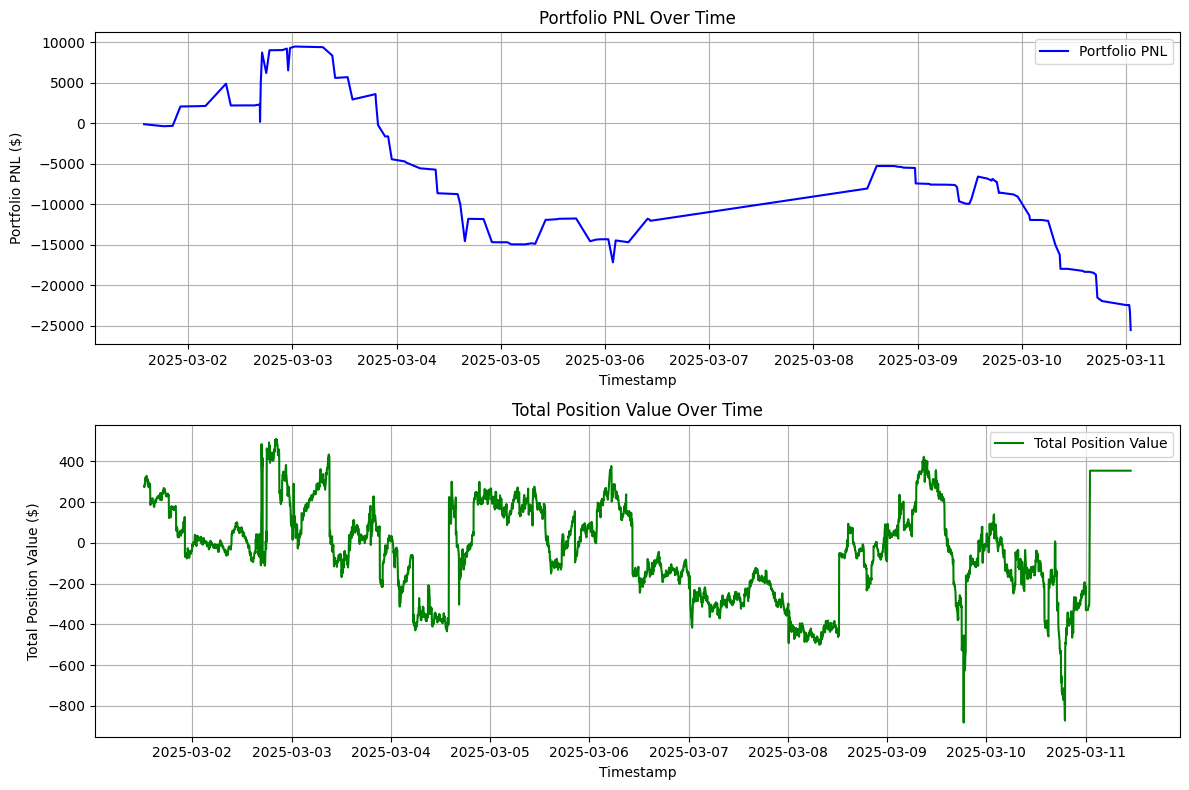

In [47]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(df_portfolio_pnl["timestamp"], df_portfolio_pnl["portfolio_pnl"], label="Portfolio PNL", color="blue")
plt.xlabel("Timestamp")
plt.ylabel("Portfolio PNL ($)")
plt.title("Portfolio PNL Over Time")
plt.grid(True)
plt.legend()

total_position_value = df_values.groupby("timestamp")["dollar_value"].sum().reset_index()
plt.subplot(2, 1, 2)
plt.plot(total_position_value["timestamp"], total_position_value["dollar_value"], label="Total Position Value", color="green")
plt.xlabel("Timestamp")
plt.ylabel("Total Position Value ($)")
plt.title("Total Position Value Over Time")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
    

Executed Positions:
                   timestamp  \
0 2025-03-01 12:20:38.977600   
1 2025-03-01 12:20:38.977600   
2 2025-03-01 12:20:38.977600   
3 2025-03-01 12:20:38.977600   
4 2025-03-01 12:20:38.977600   

                                           positions  \
0  {'LUNC-USDT-SWAP': -20140000.0, 'PYTH-USDT-SWA...   
1  {'LUNC-USDT-SWAP': -20140000.0, 'PYTH-USDT-SWA...   
2  {'LUNC-USDT-SWAP': -20140000.0, 'PYTH-USDT-SWA...   
3  {'LUNC-USDT-SWAP': -20140000.0, 'PYTH-USDT-SWA...   
4  {'LUNC-USDT-SWAP': -20140000.0, 'PYTH-USDT-SWA...   

                                          directions  
0  {'LUNC-USDT-SWAP': -1, 'PYTH-USDT-SWAP': 1, 'D...  
1  {'LUNC-USDT-SWAP': -1, 'PYTH-USDT-SWAP': 1, 'D...  
2  {'LUNC-USDT-SWAP': -1, 'PYTH-USDT-SWAP': 1, 'D...  
3  {'LUNC-USDT-SWAP': -1, 'PYTH-USDT-SWAP': 1, 'D...  
4  {'LUNC-USDT-SWAP': -1, 'PYTH-USDT-SWAP': 1, 'D...  
Processing symbols at 2025-03-01 12:20:38.977600: {'UNI-USDT-SWAP', 'ZETA-USDT-SWAP', '1INCH-USDT-SWAP', 'AXS-USDT-SWAP'

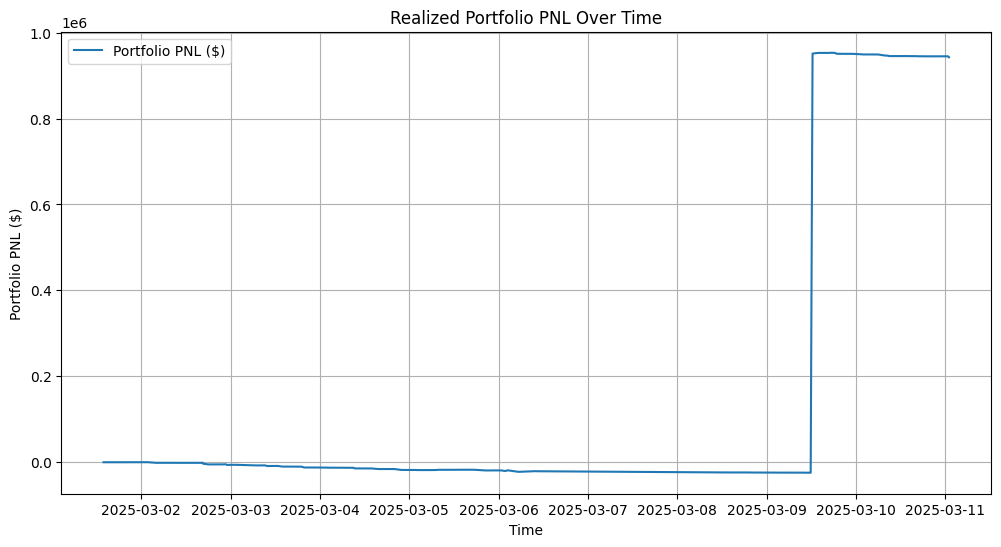

In [36]:
# Paths
exec_log_path = "okx_bot_data/current_state.pos"
price_path = "okx_bot_data/price_data_okx.csv"

# Parse executed positions
df_exec_log = parse_executed_positions_log(exec_log_path)
print("Executed Positions:")
print(df_exec_log.head())
print("=" * 60)

# Process positions
df_values, df_events = process_executed_positions(df_exec_log, df_prices)
print("Position Values:")
print(df_values.head())
print("Events:")
print(df_events.head())
print("=" * 60)

# Calculate PNL
df_position_pnl, df_portfolio_pnl, df_pnl_events = calculate_realized_pnl(df_events)
print("Position Lifetime PNL:")
print(df_position_pnl)
print("Portfolio PNL Over Time:")
print(df_portfolio_pnl)
print("PNL Events:")
print(df_pnl_events)
print("=" * 60)

# Validation
total_position_pnl = df_position_pnl["realized_pnl"].sum()
final_portfolio_pnl = df_portfolio_pnl["portfolio_pnl"].iloc[-1] if not df_portfolio_pnl.empty else 0.0
print(f"Total Position PNL: {total_position_pnl:.2f}")
print(f"Final Portfolio PNL: {final_portfolio_pnl:.2f}")
print(f"Difference: {total_position_pnl - final_portfolio_pnl:.2f}")

# Save results
df_values.to_csv("position_values.csv", index=False)
df_events.to_csv("position_events.csv", index=False)
df_position_pnl.to_csv("position_pnl.csv", index=False)
df_portfolio_pnl.to_csv("portfolio_pnl.csv", index=False)
df_pnl_events.to_csv("pnl_events.csv", index=False)

# Plot portfolio PNL
plt.figure(figsize=(12, 6))
plt.plot(df_portfolio_pnl["timestamp"].to_numpy(), df_portfolio_pnl["portfolio_pnl"].to_numpy(), label="Portfolio PNL ($)")
plt.xlabel("Time")
plt.ylabel("Portfolio PNL ($)")
plt.title("Realized Portfolio PNL Over Time")
plt.legend()
plt.grid()
plt.savefig("portfolio_pnl.png", dpi=300)
plt.show()

In [24]:
df_exec_log

,timestamp,positions,directions
0,2025-03-01 12:20:38.977600,"{'LUNC-USDT-SWAP': -20140000.0, 'PYTH-USDT-SWA...","{'LUNC-USDT-SWAP': -1, 'PYTH-USDT-SWAP': 1, 'D..."
1,2025-03-01 12:20:38.977600,"{'LUNC-USDT-SWAP': -20140000.0, 'PYTH-USDT-SWA...","{'LUNC-USDT-SWAP': -1, 'PYTH-USDT-SWAP': 1, 'D..."
2,2025-03-01 12:20:38.977600,"{'LUNC-USDT-SWAP': -20140000.0, 'PYTH-USDT-SWA...","{'LUNC-USDT-SWAP': -1, 'PYTH-USDT-SWAP': 1, 'D..."
3,2025-03-01 12:20:38.977600,"{'LUNC-USDT-SWAP': -20140000.0, 'PYTH-USDT-SWA...","{'LUNC-USDT-SWAP': -1, 'PYTH-USDT-SWAP': 1, 'D..."
4,2025-03-01 12:20:38.977600,"{'LUNC-USDT-SWAP': -20140000.0, 'PYTH-USDT-SWA...","{'LUNC-USDT-SWAP': -1, 'PYTH-USDT-SWAP': 1, 'D..."
...,...,...,...
564,2025-03-11 10:12:35.773900,"{'IMX-USDT-SWAP': 1.0, '1INCH-USDT-SWAP': 7297...","{'IMX-USDT-SWAP': 1, '1INCH-USDT-SWAP': 1, 'LU..."
565,2025-03-11 10:22:34.885900,"{'IMX-USDT-SWAP': 1.0, '1INCH-USDT-SWAP': 7297...","{'IMX-USDT-SWAP': 1, '1INCH-USDT-SWAP': 1, 'LU..."
566,2025-03-11 10:32:43.423900,"{'IMX-USDT-SWAP': 1.0, '1INCH-USDT-SWAP': 7297...","{'IMX-USDT-SWAP': 1, '1INCH-USDT-SWAP': 1, 'LU..."
567,2025-03-11 10:42:40.760700,"{'IMX-USDT-SWAP': 1.0, '1INCH-USDT-SWAP': 7297...","{'IMX-USDT-SWAP': 1, '1INCH-USDT-SWAP': 1, 'LU..."


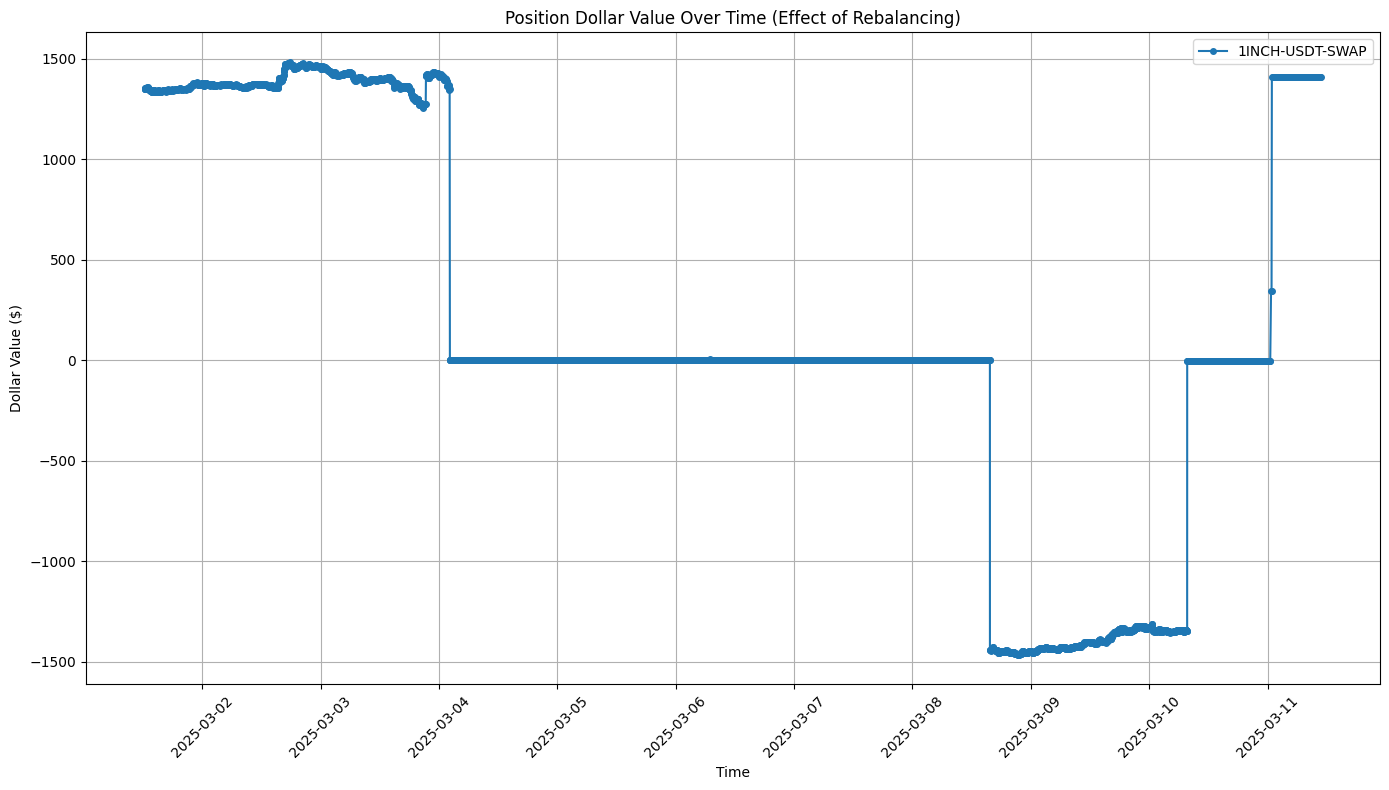

In [40]:
# Plot position dollar values for specific symbols
symbols_to_plot = ['1INCH-USDT-SWAP']  # Replace with your desired symbols
plt.figure(figsize=(14, 8))

for symbol in symbols_to_plot:
    df_symbol = df_values[df_values["symbol"] == symbol]
    if not df_symbol.empty:
        plt.plot(df_symbol["timestamp"].to_numpy(), df_symbol["dollar_value"].to_numpy(), label=f"{symbol}", marker='o', markersize=4)
    else:
        print(f"WARNING: No data found for {symbol} in df_values")

plt.xlabel("Time")
plt.ylabel("Dollar Value ($)")
plt.title("Position Dollar Value Over Time (Effect of Rebalancing)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("position_values_over_time.png", dpi=300)
plt.show()

In [55]:
import re
import pandas as pd
import numpy as np
from datetime import datetime

def parse_executed_positions_log(log_path: str) -> pd.DataFrame:
    """
    Parse the executed positions log file into a DataFrame.
    Expected log lines are in the format:
      2025/03/08 12:22:31.848557:'LUNC-USDT-SWAP':-21450000.0, ... ,'equity':... 
    This function ignores the 'equity' field and creates two columns:
      - positions: a dict {symbol: float}
      - directions: a dict {symbol: int} where 1 means long and -1 means short.
    """
    # Regex pattern: symbol in single quotes then a colon and a number (int or float)
    pattern = re.compile(r"'([^']+)':([-]?\d+(?:\.\d+)?)")
    rows = []
    try:
        with open(log_path, 'r') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                # Extract the timestamp (assumed to be first 24 characters)
                dt_str = line[:24]
                rest = line[24:].strip()
                dt = datetime.strptime(dt_str, "%Y/%m/%d %H:%M:%S.%f")
                pairs = pattern.findall(rest)
                positions_dict = {}
                for sym, pos in pairs:
                    if sym == 'equity':
                        continue
                    # Optionally, validate symbol format (adjust regex as needed)
                    if sym.isdigit() or not re.match(r'^[A-Z0-9]+-[A-Z]+-(SWAP|PERP)$', sym):
                        print(f"WARNING: Skipping unexpected symbol '{sym}' at {dt_str}")
                        continue
                    positions_dict[sym] = float(pos)
                directions_dict = {sym: (1 if pos > 0 else -1 if pos < 0 else 0)
                                   for sym, pos in positions_dict.items()}
                rows.append({
                    "timestamp": dt,
                    "positions": positions_dict,
                    "directions": directions_dict
                })
    except FileNotFoundError as e:
        print(f"ERROR: File not found: {log_path}")
        raise e
    df = pd.DataFrame(rows)
    df.sort_values("timestamp", inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df


def get_next_bar_price(symbol: str, ts: pd.Timestamp, df_prices: pd.DataFrame, column: str = "close", fallback: bool = True) -> float:
    """
    Look up the price for a given symbol at or immediately after the provided timestamp.
    If no price exists at or after ts and fallback is True, use the most recent price before ts.
    """
    col = f"{symbol}_{column}"
    if col not in df_prices.columns:
        return np.nan
    prices_after = df_prices[df_prices.index >= ts][col]
    if not prices_after.empty:
        return prices_after.iloc[0]
    if fallback:
        prices_before = df_prices[df_prices.index <= ts][col]
        if not prices_before.empty:
            return prices_before.iloc[-1]
    return np.nan

def generate_position_events(df_log: pd.DataFrame, df_prices: pd.DataFrame) -> pd.DataFrame:
    """
    Compares successive snapshots in the executed positions log and emits events.
    Events have:
      - symbol
      - timestamp (of the event)
      - action: "open", "close", or "rebalance"
      - old_size, new_size, price, old_value, new_value
    If the direction changes (for example, from long to short) the event is split into a close and an open.
    """
    # Remove duplicate snapshots (using a sorted tuple representation)
    df_log['positions_hashable'] = df_log['positions'].apply(lambda x: tuple(sorted(x.items())))
    df_log = df_log.drop_duplicates(subset=["timestamp", "positions_hashable"], keep="first")
    df_log = df_log.drop(columns=["positions_hashable"])
    df_log.sort_values("timestamp", inplace=True)
    df_log.reset_index(drop=True, inplace=True)
    
    # Prepend a dummy row with empty positions
    first_ts = df_log.iloc[0]["timestamp"] if not df_log.empty else pd.Timestamp.now()
    dummy_ts = first_ts - pd.Timedelta(microseconds=1)
    dummy_row = pd.DataFrame({"timestamp": [dummy_ts], "positions": [{}], "directions": [{}]})
    df_log = pd.concat([dummy_row, df_log], ignore_index=True)
    
    # Warn if any symbol is missing a price column
    all_symbols = set()
    for pos in df_log['positions']:
        all_symbols.update(pos.keys())
    missing_price_symbols = set()
    for sym in all_symbols:
        price_col = f"{sym}_close"
        if price_col not in df_prices.columns:
            print(f"WARNING: Price column {price_col} not found; events for {sym} will use price 0.0")
            missing_price_symbols.add(sym)
    
    events = []
    for i in range(len(df_log) - 1):
        curr_ts = df_log.iloc[i]["timestamp"]
        next_ts = df_log.iloc[i+1]["timestamp"]
        curr_pos = df_log.iloc[i]["positions"]
        next_pos = df_log.iloc[i+1]["positions"]
        curr_dir = df_log.iloc[i]["directions"]
        next_dir = df_log.iloc[i+1]["directions"]
        
        symbols = set(curr_pos.keys()).union(next_pos.keys())
        # Process each symbol individually:
        for sym in symbols:
            old_size = curr_pos.get(sym, 0.0)
            new_size = next_pos.get(sym, 0.0)
            old_dir = curr_dir.get(sym, 0)
            new_dir = next_dir.get(sym, 0)
            
            if sym in missing_price_symbols:
                price = 0.0
            else:
                price = get_next_bar_price(sym, next_ts, df_prices, column="close", fallback=True)
                if pd.isna(price):
                    print(f"WARNING: No price for {sym} at {next_ts}")
                    price = 0.0
            old_value = old_size * price
            new_value = new_size * price
            
            if old_dir != new_dir:
                # If going from 0 to non-zero (open) or non-zero to 0 (close)
                if old_dir == 0 and new_dir != 0:
                    events.append({
                        "symbol": sym,
                        "timestamp": next_ts,
                        "action": "open",
                        "old_size": old_size,
                        "new_size": new_size,
                        "price": price,
                        "old_value": 0.0,
                        "new_value": new_value
                    })
                elif old_dir != 0 and new_dir == 0:
                    events.append({
                        "symbol": sym,
                        "timestamp": next_ts,
                        "action": "close",
                        "old_size": old_size,
                        "new_size": new_size,
                        "price": price,
                        "old_value": old_value,
                        "new_value": 0.0
                    })
                else:
                    # Direction flip: treat as a close followed by an open
                    events.append({
                        "symbol": sym,
                        "timestamp": next_ts,
                        "action": "close",
                        "old_size": old_size,
                        "new_size": 0.0,
                        "price": price,
                        "old_value": old_value,
                        "new_value": 0.0
                    })
                    events.append({
                        "symbol": sym,
                        "timestamp": next_ts,
                        "action": "open",
                        "old_size": 0.0,
                        "new_size": new_size,
                        "price": price,
                        "old_value": 0.0,
                        "new_value": new_value
                    })
            elif old_dir == new_dir and old_dir != 0 and abs(new_size - old_size) > 1e-6:
                # A position size change without a change in direction is a rebalance.
                events.append({
                    "symbol": sym,
                    "timestamp": next_ts,
                    "action": "rebalance",
                    "old_size": old_size,
                    "new_size": new_size,
                    "price": price,
                    "old_value": old_value,
                    "new_value": new_value
                })
    df_events = pd.DataFrame(events)
    df_events.sort_values("timestamp", inplace=True)
    df_events.reset_index(drop=True, inplace=True)
    return df_events

def calculate_portfolio_pnl(df_events: pd.DataFrame) -> pd.DataFrame:
    """
    Iterates over position events and “realizes” pnl when positions are reduced or closed.
    Maintains a dictionary of open positions (with a cost basis) and returns a DataFrame
    with the timestamp and cumulative portfolio pnl.
    """
    open_positions = {}  # key: symbol, value: dict with "entry_time", "size", "total_cost", "total_size"
    portfolio_pnl_records = []
    total_portfolio_pnl = 0.0

    for idx, event in df_events.iterrows():
        symbol = event["symbol"]
        ts = event["timestamp"]
        action = event["action"]
        old_size = event["old_size"]
        new_size = event["new_size"]
        price = event["price"]
        if pd.isna(price):
            print(f"ERROR: Missing price for {symbol} at {ts}, skipping event.")
            continue

        if action == "open":
            # Open a new position (initialize cost basis)
            open_positions[symbol] = {
                "entry_time": ts,
                "size": new_size,
                "total_cost": new_size * price,
                "total_size": abs(new_size)
            }
            print(f"Open {symbol} at {ts}: size={new_size}, price={price}, cost={open_positions[symbol]['total_cost']}")
        elif action == "rebalance":
            if symbol not in open_positions:
                print(f"WARNING: Rebalance event without open position for {symbol} at {ts}")
                continue
            pos = open_positions[symbol]
            # For rebalances, we assume that a reduction (selling long or buying to cover short) realizes pnl.
            size_change = old_size - new_size  # positive if reducing long (selling) or reducing short (buying to cover)
            mean_acq_price = pos["total_cost"] / pos["total_size"] if pos["total_size"] != 0 else 0.0
            realized_pnl = 0.0
            if old_size > 0:  # long position
                if size_change > 0:  # selling part of the long
                    realized_pnl = size_change * (price - mean_acq_price)
                    pos["total_cost"] -= size_change * mean_acq_price
                    pos["total_size"] -= size_change
                    pos["size"] = new_size
                    print(f"Rebalance Sell (long) {symbol} at {ts}: sold={size_change}, price={price}, pnl={realized_pnl}")
                else:
                    # Buying more: no pnl is realized; update cost basis
                    pos["total_cost"] += abs(size_change) * price
                    pos["total_size"] += abs(size_change)
                    pos["size"] = new_size
                    print(f"Rebalance Buy (long) {symbol} at {ts}: bought={abs(size_change)}, price={price}")
            elif old_size < 0:  # short position
                if size_change > 0:  # buying to cover part of the short
                    realized_pnl = abs(size_change) * (mean_acq_price - price)
                    pos["total_cost"] += abs(size_change) * mean_acq_price
                    pos["total_size"] -= abs(size_change)
                    pos["size"] = new_size
                    print(f"Rebalance Buy (cover short) {symbol} at {ts}: covered={abs(size_change)}, price={price}, pnl={realized_pnl}")
                else:
                    # Selling more: increasing short position; update cost basis without realizing pnl
                    pos["total_cost"] -= abs(size_change) * price
                    pos["total_size"] += abs(size_change)
                    pos["size"] = new_size
                    print(f"Rebalance Sell (increase short) {symbol} at {ts}: sold additional={abs(size_change)}, price={price}")
            total_portfolio_pnl += realized_pnl
            portfolio_pnl_records.append({"timestamp": ts, "portfolio_pnl": total_portfolio_pnl})
        elif action == "close":
            if symbol not in open_positions:
                print(f"WARNING: Close event without open position for {symbol} at {ts}")
                continue
            pos = open_positions[symbol]
            mean_acq_price = pos["total_cost"] / pos["total_size"] if pos["total_size"] != 0 else 0.0
            if old_size > 0:  # closing long position
                realized_pnl = old_size * (price - mean_acq_price)
            elif old_size < 0:  # closing short position
                realized_pnl = abs(old_size) * (mean_acq_price - price)
            total_portfolio_pnl += realized_pnl
            portfolio_pnl_records.append({"timestamp": ts, "portfolio_pnl": total_portfolio_pnl})
            print(f"Close {symbol} at {ts}: size={old_size}, price={price}, pnl={realized_pnl}")
            del open_positions[symbol]
    df_portfolio_pnl = pd.DataFrame(portfolio_pnl_records)
    df_portfolio_pnl.sort_values("timestamp", inplace=True)
    df_portfolio_pnl.reset_index(drop=True, inplace=True)
    return df_portfolio_pnl

def calculate_position_pnl(df_events: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the lifetime (entry-to-exit) realized pnl for each individual position.
    Returns a DataFrame with columns: symbol, entry_time, exit_time, realized_pnl.
    """
    open_positions = {}
    position_pnl = {}  # key: f"{symbol}_{entry_time}", value: cumulative pnl
    
    for idx, event in df_events.iterrows():
        symbol = event["symbol"]
        ts = event["timestamp"]
        action = event["action"]
        old_size = event["old_size"]
        new_size = event["new_size"]
        price = event["price"]
        if pd.isna(price):
            print(f"ERROR: Missing price for {symbol} at {ts}, skipping event.")
            continue
        
        if action == "open":
            open_positions[symbol] = {
                "entry_time": ts,
                "size": new_size,
                "total_cost": new_size * price,
                "total_size": abs(new_size)
            }
            key = f"{symbol}_{ts}"
            position_pnl[key] = 0.0
            print(f"Open {symbol} at {ts}: size={new_size}, price={price}")
        elif action == "rebalance":
            if symbol not in open_positions:
                print(f"WARNING: Rebalance event without open position for {symbol} at {ts}")
                continue
            pos = open_positions[symbol]
            key = f"{symbol}_{pos['entry_time']}"
            size_change = old_size - new_size
            mean_acq_price = pos["total_cost"] / pos["total_size"] if pos["total_size"] != 0 else 0.0
            realized_pnl = 0.0
            if old_size > 0:  # long
                if size_change > 0:
                    realized_pnl = size_change * (price - mean_acq_price)
                    pos["total_cost"] -= size_change * mean_acq_price
                    pos["total_size"] -= size_change
                    pos["size"] = new_size
                    print(f"Rebalance Sell (long) {symbol} at {ts}: sold={size_change}, price={price}, pnl={realized_pnl}")
                else:
                    pos["total_cost"] += abs(size_change) * price
                    pos["total_size"] += abs(size_change)
                    pos["size"] = new_size
                    print(f"Rebalance Buy (long) {symbol} at {ts}: bought={abs(size_change)}, price={price}")
                position_pnl[key] += realized_pnl
            elif old_size < 0:  # short
                if size_change > 0:
                    realized_pnl = abs(size_change) * (mean_acq_price - price)
                    pos["total_cost"] += abs(size_change) * mean_acq_price
                    pos["total_size"] -= abs(size_change)
                    pos["size"] = new_size
                    print(f"Rebalance Buy (cover short) {symbol} at {ts}: covered={abs(size_change)}, price={price}, pnl={realized_pnl}")
                else:
                    pos["total_cost"] -= abs(size_change) * price
                    pos["total_size"] += abs(size_change)
                    pos["size"] = new_size
                    print(f"Rebalance Sell (increase short) {symbol} at {ts}: sold additional={abs(size_change)}, price={price}")
                position_pnl[key] += realized_pnl
        elif action == "close":
            if symbol not in open_positions:
                print(f"WARNING: Close event without open position for {symbol} at {ts}")
                continue
            pos = open_positions[symbol]
            key = f"{symbol}_{pos['entry_time']}"
            mean_acq_price = pos["total_cost"] / pos["total_size"] if pos["total_size"] != 0 else 0.0
            if old_size > 0:
                realized_pnl = old_size * (price - mean_acq_price)
            elif old_size < 0:
                realized_pnl = abs(old_size) * (mean_acq_price - price)
            position_pnl[key] += realized_pnl
            print(f"Close {symbol} at {ts}: size={old_size}, price={price}, pnl={realized_pnl}")
            del open_positions[symbol]
    
    records = []
    for key, pnl in position_pnl.items():
        # key format: "symbol_entrytime"
        symbol, entry_time_str = key.rsplit("_", 1)
        entry_time = pd.Timestamp(entry_time_str)
        # Find the exit time: earliest close event for this symbol after the entry
        exit_time = df_events[(df_events["symbol"] == symbol) &
                              (df_events["timestamp"] >= entry_time) &
                              (df_events["action"] == "close")]["timestamp"].min()
        records.append({
            "symbol": symbol,
            "entry_time": entry_time,
            "exit_time": exit_time,
            "realized_pnl": pnl
        })
    df_position_pnl = pd.DataFrame(records)
    df_position_pnl.sort_values("entry_time", inplace=True)
    df_position_pnl.reset_index(drop=True, inplace=True)
    return df_position_pnl




In [62]:
import pandas as pd
import numpy as np

def calculate_cost_average_realized_pnl(df_events: pd.DataFrame):
    """
    Calculates realized PNL using a cost–averaging method.

    For each symbol, we maintain a single “lot” with:
      - size: current open position (positive for long, negative for short)
      - avg_price: weighted–average acquisition price (the cost basis)
      - entry_time: when the current lot was initiated
      - realized_pnl_lot: cumulative PNL realized for that lot so far

    When adding to a position (i.e. when the trade’s delta is in the same direction as the current open position),
    the weighted average is updated. When reducing the position (i.e. when the trade’s delta is opposite in sign),
    we calculate the realized PNL on the reduced quantity using the current average price and do NOT update the cost basis.
    If the reduction closes (or reverses) the position, we record the lifetime PNL of that lot.

    Parameters:
      df_events: DataFrame with columns:
         - symbol: trading symbol (e.g. 'UNI-USDT-SWAP')
         - timestamp: event timestamp (datetime)
         - action: a string such as "open", "rebalance", "close" (the logic here uses the size change)
         - old_size: position size before the event
         - new_size: position size after the event
         - price: execution price at the event
         
    Returns:
      df_position_pnl: DataFrame with one row per closed lot, with columns:
         symbol, entry_time, exit_time, realized_pnl
      df_portfolio_pnl: DataFrame with columns timestamp, cumulative_portfolio_pnl (the cumulative realized PNL timeline)
    """
    positions = {}        # Dict to hold open lot info per symbol.
    closed_positions = [] # List to store closed (fully realized) lot records.
    portfolio_timeline = []
    cumulative_portfolio_pnl = 0.0

    # Ensure events are processed in chronological order.
    df_events = df_events.sort_values("timestamp").reset_index(drop=True)

    for idx, event in df_events.iterrows():
        symbol = event['symbol']
        ts = event['timestamp']
        price = event['price']
        old_size = event.get('old_size', 0.0)
        new_size = event.get('new_size', 0.0)
        # delta represents the change in position size:
        delta = new_size - old_size
        pnl_realized = 0.0

        if symbol not in positions:
            # No open lot exists – open a new one if delta is nonzero.
            if abs(delta) > 1e-8:
                positions[symbol] = {
                    "size": delta,
                    "avg_price": price,
                    "entry_time": ts,
                    "realized_pnl_lot": 0.0
                }
                pnl_realized = 0.0
        else:
            pos = positions[symbol]
            current_size = pos["size"]
            avg_price = pos["avg_price"]

            # Determine whether this trade is an addition (same direction)
            # or a reduction (opposite direction) relative to the current open position.
            if current_size * delta > 0:
                # Addition: the new trade is in the same direction as the current open position.
                new_total = current_size + delta
                # Update the weighted average cost.
                new_avg = (current_size * avg_price + delta * price) / new_total
                pos["size"] = new_total
                pos["avg_price"] = new_avg
                # No realized PNL from an addition.
                pnl_realized = 0.0
            elif current_size * delta < 0:
                # Reduction: the trade is in the opposite direction to the current position.
                # Compute the quantity reduced.
                qty_reduced = abs(delta)
                # For a long position (current_size positive), realized PNL = (current_price - avg_price) * qty_reduced.
                # For a short position (current_size negative), realized PNL = (avg_price - current_price) * qty_reduced.
                if current_size > 0:
                    pnl_realized = (price - avg_price) * qty_reduced
                else:
                    pnl_realized = (avg_price - price) * qty_reduced

                pos["size"] = current_size + delta  # This reduces the open position.
                pos["realized_pnl_lot"] += pnl_realized

                # If the reduction closes or reverses the position, record the lot.
                if abs(pos["size"]) < 1e-8 or np.sign(pos["size"]) != np.sign(current_size):
                    closed_positions.append({
                        "symbol": symbol,
                        "entry_time": pos["entry_time"],
                        "exit_time": ts,
                        "realized_pnl": pos["realized_pnl_lot"]
                    })
                    del positions[symbol]
            else:
                # delta == 0; no change.
                pnl_realized = 0.0

        cumulative_portfolio_pnl += pnl_realized
        portfolio_timeline.append({'timestamp': ts, 'cumulative_portfolio_pnl': cumulative_portfolio_pnl})

    df_position_pnl = pd.DataFrame(closed_positions)
    if not df_position_pnl.empty:
        df_position_pnl = df_position_pnl.sort_values("entry_time").reset_index(drop=True)

    df_portfolio_pnl = pd.DataFrame(portfolio_timeline)
    df_portfolio_pnl = df_portfolio_pnl.sort_values("timestamp").reset_index(drop=True)

    return df_position_pnl, df_portfolio_pnl

# ----------------------------------------
# EXAMPLE USAGE:
# Suppose you already have an events DataFrame, e.g. from:
# df_events = generate_position_events(df_exec_log, df_prices)
#
# Then you can compute the cost–average realized PNL as follows:
#



In [63]:

exec_log_path = "okx_bot_data/current_state.pos"
price_path = "okx_bot_data/price_data_okx.csv"

print("Parsing executed positions log...")
df_exec_log = parse_executed_positions_log(exec_log_path)
print(df_exec_log.head())

print("\nLoading price data...")
df_prices = load_price_data(price_path)
print("Price data columns:")
print(df_prices.columns)

print("\nGenerating position events...")
df_events = generate_position_events(df_exec_log, df_prices)
print(df_events.head(10))



Parsing executed positions log...
                   timestamp  \
0 2025-03-01 12:20:38.977600   
1 2025-03-01 12:20:38.977600   
2 2025-03-01 12:20:38.977600   
3 2025-03-01 12:20:38.977600   
4 2025-03-01 12:20:38.977600   

                                           positions  \
0  {'LUNC-USDT-SWAP': -20140000.0, 'PYTH-USDT-SWA...   
1  {'LUNC-USDT-SWAP': -20140000.0, 'PYTH-USDT-SWA...   
2  {'LUNC-USDT-SWAP': -20140000.0, 'PYTH-USDT-SWA...   
3  {'LUNC-USDT-SWAP': -20140000.0, 'PYTH-USDT-SWA...   
4  {'LUNC-USDT-SWAP': -20140000.0, 'PYTH-USDT-SWA...   

                                          directions  
0  {'LUNC-USDT-SWAP': -1, 'PYTH-USDT-SWAP': 1, 'D...  
1  {'LUNC-USDT-SWAP': -1, 'PYTH-USDT-SWAP': 1, 'D...  
2  {'LUNC-USDT-SWAP': -1, 'PYTH-USDT-SWAP': 1, 'D...  
3  {'LUNC-USDT-SWAP': -1, 'PYTH-USDT-SWAP': 1, 'D...  
4  {'LUNC-USDT-SWAP': -1, 'PYTH-USDT-SWAP': 1, 'D...  

Loading price data...
Price data columns:
Index(['AXS-USDT-SWAP_open', 'AXS-USDT-SWAP_high', 'AXS-USDT-SW

In [ ]:
# -------------------------------
# EXAMPLE USAGE:
# Suppose you have already generated your events DataFrame (df_events)
# with columns: symbol, timestamp, action, old_size, new_size, price

# For example, if you load your events from your log parser:
# df_events = generate_position_events(df_exec_log, df_prices)

# Now calculate cost-average realized PNL and the portfolio timeline:
df_position_pnl, df_portfolio_pnl = calculate_cost_average_realized_pnl(df_events)
#
print("Closed Lot PNL:")
print(df_position_pnl)
#
print("\nPortfolio Realized PNL Timeline:")
print(df_portfolio_pnl)

Closed Lot PNL:
             symbol                 entry_time                  exit_time  \
0     UMA-USDT-SWAP 2025-03-01 12:20:38.977600 2025-03-01 13:50:38.730200   
1     FIL-USDT-SWAP 2025-03-01 12:20:38.977600 2025-03-02 23:26:37.515500   
2    BLUR-USDT-SWAP 2025-03-01 12:20:38.977600 2025-03-08 12:22:31.848500   
3     ATH-USDT-SWAP 2025-03-01 12:20:38.977600 2025-03-03 07:00:36.048300   
4     DOT-USDT-SWAP 2025-03-01 12:20:38.977600 2025-03-03 09:10:45.617000   
..              ...                        ...                        ...   
93    KSM-USDT-SWAP 2025-03-08 12:22:31.848500 2025-03-09 11:52:31.231300   
94  1INCH-USDT-SWAP 2025-03-08 15:42:24.260600 2025-03-11 00:42:38.448100   
95    FIL-USDT-SWAP 2025-03-08 18:22:31.041600 2025-03-09 18:52:31.582400   
96     OP-USDT-SWAP 2025-03-08 20:12:22.292200 2025-03-09 06:42:27.028200   
97    IMX-USDT-SWAP 2025-03-10 06:02:30.498100 2025-03-11 01:02:39.097300   

    realized_pnl  
0      12.650400  
1    -155.067000  
2 

In [65]:
df_position_pnl.to_csv("positions_pnl.csv", index=False)
df_portfolio_pnl.to_csv("portfolio_pnl.csv", index=False)